In [2]:
import logging
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import (
        train_test_split,
        cross_validate,
        cross_val_predict,
        GridSearchCV
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    PowerTransformer,
    LabelEncoder,
    MinMaxScaler,
    OneHotEncoder
)
from sklearn.ensemble import(
    RandomForestClassifier
)
from sklearn.metrics import(
    accuracy_score,
    matthews_corrcoef,
    f1_score,
    classification_report,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    DetCurveDisplay
)
from sklearn.inspection import permutation_importance
import kagglehub
logger = logging.getLogger()
logger.setLevel(logging.INFO) 

In [3]:
path = kagglehub.dataset_download("adilshamim8/student-depression-dataset")

print("Path to dataset files:", path)

Path to dataset files: /home/vscode/.cache/kagglehub/datasets/adilshamim8/student-depression-dataset/versions/1


In [4]:
dataset_path = path + "/student_depression_dataset.csv"
df_raw = pd.read_csv(dataset_path)
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27901 entries, 0 to 27900
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     27901 non-null  int64  
 1   Gender                                 27901 non-null  object 
 2   Age                                    27901 non-null  float64
 3   City                                   27901 non-null  object 
 4   Profession                             27901 non-null  object 
 5   Academic Pressure                      27901 non-null  float64
 6   Work Pressure                          27901 non-null  float64
 7   CGPA                                   27901 non-null  float64
 8   Study Satisfaction                     27901 non-null  float64
 9   Job Satisfaction                       27901 non-null  float64
 10  Sleep Duration                         27901 non-null  object 
 11  Di

In [5]:
df_raw.sample(10, random_state=2025)

,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
11442,57854,Male,28.0,Meerut,Student,4.0,0.0,9.11,3.0,0.0,'More than 8 hours',Unhealthy,MD,Yes,2.0,5.0,Yes,1
26498,133634,Female,30.0,Jaipur,Student,3.0,0.0,6.75,1.0,0.0,'Less than 5 hours',Unhealthy,BBA,Yes,11.0,2.0,Yes,1
17475,88401,Male,28.0,Bangalore,Student,3.0,0.0,8.17,5.0,0.0,'7-8 hours',Unhealthy,'Class 12',Yes,12.0,2.0,No,1
27833,140290,Female,21.0,Kalyan,Student,1.0,0.0,6.82,1.0,0.0,'Less than 5 hours',Moderate,B.Arch,No,2.0,3.0,No,0
20102,101723,Male,34.0,Jaipur,Student,4.0,0.0,5.12,4.0,0.0,'Less than 5 hours',Unhealthy,PhD,Yes,7.0,5.0,Yes,1
1554,8025,Female,21.0,Kolkata,Student,5.0,0.0,9.84,5.0,0.0,'Less than 5 hours',Moderate,B.Arch,Yes,8.0,2.0,Yes,1
10170,51422,Female,24.0,Jaipur,Student,1.0,0.0,8.59,3.0,0.0,'7-8 hours',Unhealthy,MBBS,Yes,12.0,2.0,Yes,0
4378,21965,Female,28.0,Chennai,Student,3.0,0.0,6.75,3.0,0.0,'More than 8 hours',Healthy,B.Arch,No,9.0,1.0,No,0
18967,96049,Male,31.0,Chennai,Student,1.0,0.0,8.77,1.0,0.0,'Less than 5 hours',Healthy,B.Tech,No,2.0,3.0,Yes,0
4896,24529,Male,29.0,Ludhiana,Student,3.0,0.0,7.88,3.0,0.0,'Less than 5 hours',Moderate,B.Ed,Yes,10.0,2.0,Yes,1


In [6]:
df_baking = df_raw.copy()
df_baking.columns = df_baking.columns.str.lower()
df_baking.columns = df_baking.columns.str.replace(" ", "_")
df_baking.columns = df_baking.columns.str.replace("/", "")
df_baking.columns = df_baking.columns.str.replace("?", "")
df_baking = df_baking.drop(columns=['id','work_pressure','job_satisfaction'], axis=1)
# se eliminan las variables 'work_pressure','job_satisfaction', porque los predictores con 
# varianza cercana a cero (o predictores con un solo valor), se considera que tienen menor poder predictivo
df_baking['gender'] = df_baking['gender'].astype('category')
df_baking['city'] = df_baking['city'].astype('category')
df_baking['profession'] = df_baking['profession'].astype('category')
df_baking['sleep_duration'] = df_baking['sleep_duration'].astype('category')
df_baking['dietary_habits'] = df_baking['dietary_habits'].astype('category')
df_baking['degree'] = df_baking['degree'].astype('category')
df_baking['have_you_ever_had_suicidal_thoughts_'] = df_baking['have_you_ever_had_suicidal_thoughts_'].astype('category')
df_baking['family_history_of_mental_illness'] = df_baking['family_history_of_mental_illness'].astype('category')
df_baking['study_satisfaction'] = df_baking['study_satisfaction'].astype('category')
df_baking['academic_pressure'] = df_baking['academic_pressure'].astype('category')
df_baking['depression'] = df_baking['depression'].apply(lambda x: 'si' if x==1 else 'no')
df_baking['depression'] = df_baking['depression'].astype('category')
df = df_baking.copy()
df.head()

,gender,age,city,profession,academic_pressure,cgpa,study_satisfaction,sleep_duration,dietary_habits,degree,have_you_ever_had_suicidal_thoughts_,workstudy_hours,financial_stress,family_history_of_mental_illness,depression
0,Male,33.0,Visakhapatnam,Student,5.0,8.97,2.0,'5-6 hours',Healthy,B.Pharm,Yes,3.0,1.0,No,si
1,Female,24.0,Bangalore,Student,2.0,5.90,5.0,'5-6 hours',Moderate,BSc,No,3.0,2.0,Yes,no
2,Male,31.0,Srinagar,Student,3.0,7.03,5.0,'Less than 5 hours',Healthy,BA,No,9.0,1.0,Yes,no
3,Female,28.0,Varanasi,Student,3.0,5.59,2.0,'7-8 hours',Moderate,BCA,Yes,4.0,5.0,Yes,si
4,Female,25.0,Jaipur,Student,4.0,8.13,3.0,'5-6 hours',Moderate,M.Tech,Yes,1.0,1.0,No,no


In [7]:
df_train, df_test = train_test_split(
    df,
    test_size=0.2,
    stratify= df['depression'],
    random_state=2025
)
df_train, df_val = train_test_split(
    df_train,
    test_size=0.2,
    stratify= df_train['depression'],
    random_state=2025
)
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
df_train.shape, df_val.shape, df_test.shape

((17856, 15), (4464, 15), (5581, 15))

In [8]:
display(df_train.describe(include='number').T)
display(df_train.describe(include='category').T)

,count,mean,std,min,25%,50%,75%,max
age,17856.0,25.812276,4.893070,18.0,21.00,26.00,30.00,58.0
cgpa,17856.0,7.645809,1.471594,0.0,6.28,7.77,8.91,10.0
workstudy_hours,17856.0,7.197917,3.676765,0.0,4.00,8.00,10.00,12.0


,count,unique,top,freq
gender,17856,2,Male,9908
city,17856,45,Kalyan,1056
profession,17856,10,Student,17840
academic_pressure,17856.0,6.0,3.0,4761.0
study_satisfaction,17856.0,6.0,4.0,4073.0
sleep_duration,17856,5,'Less than 5 hours',5355
dietary_habits,17856,4,Unhealthy,6620
degree,17856,28,'Class 12',3906
have_you_ever_had_suicidal_thoughts_,17856,2,Yes,11279
family_history_of_mental_illness,17856,2,No,9286


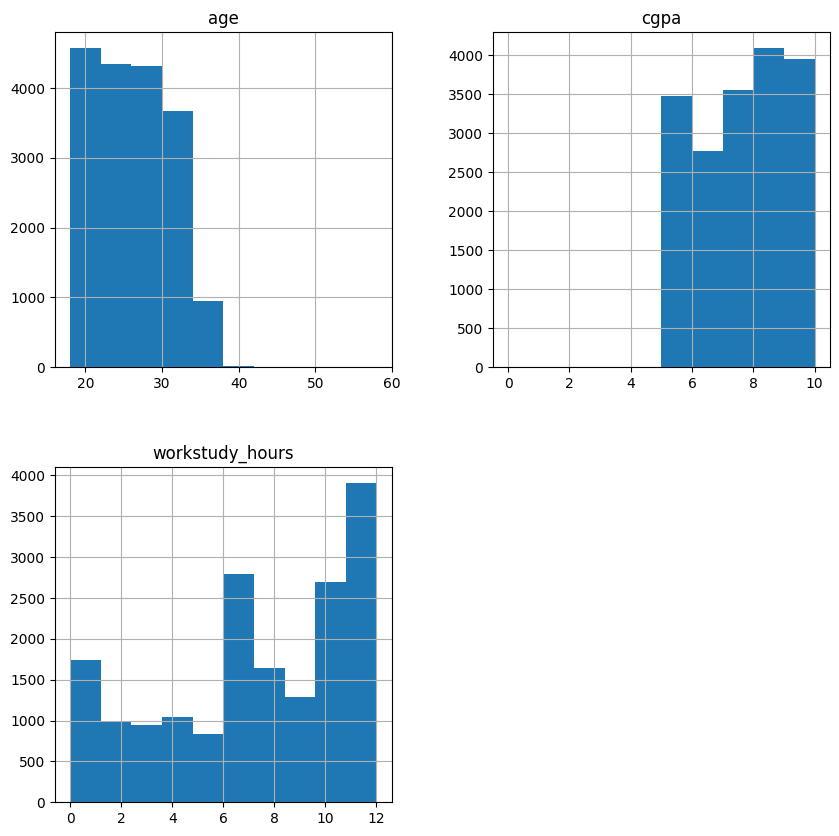

In [9]:
df_train.hist(figsize=(10,10))
plt.show()

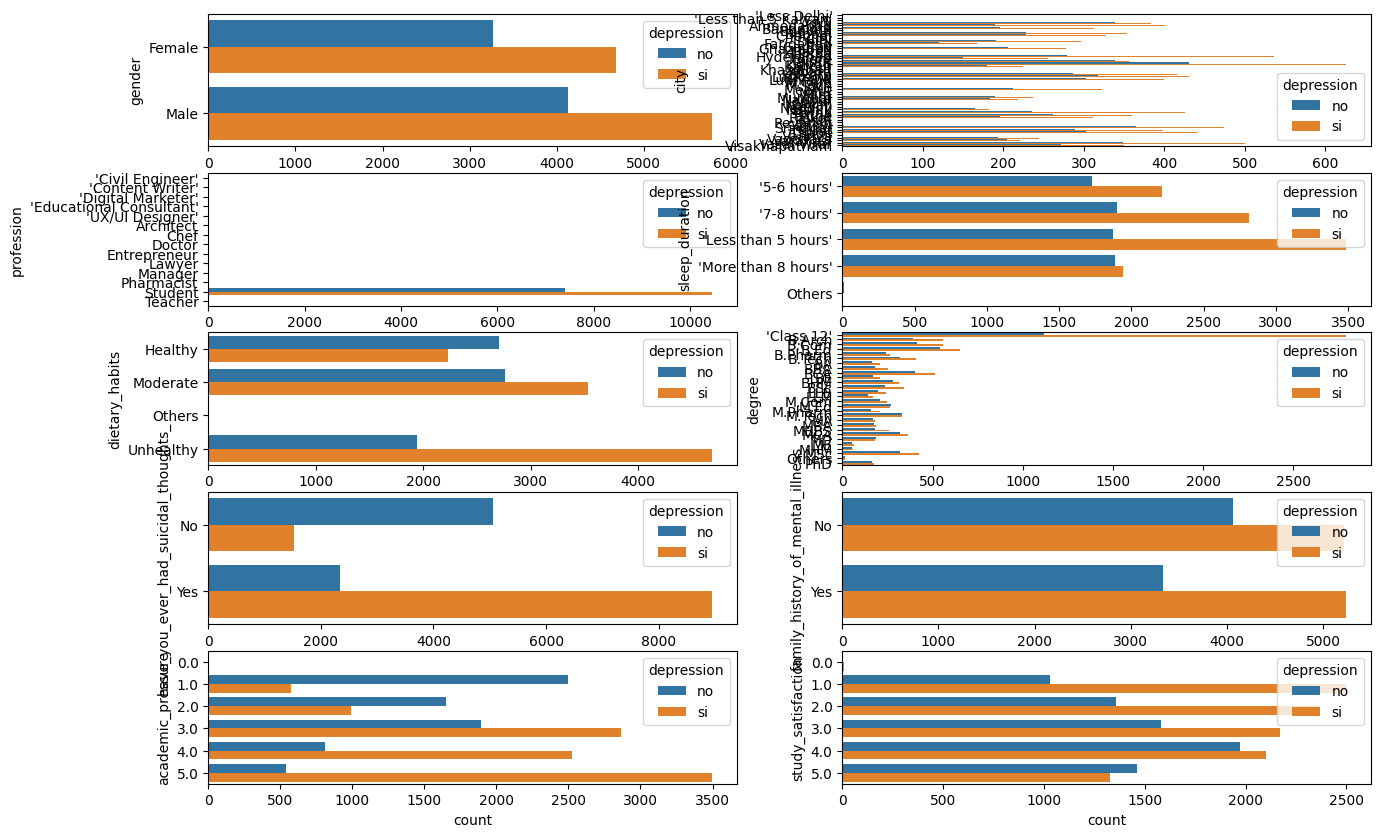

In [10]:
fig, ax = plt.subplots(5,2, figsize=(15,10))
sns.countplot(data = df_train, y = 'gender', hue='depression', ax = ax[0,0])
sns.countplot(data = df_train, y = 'city', hue='depression', ax = ax[0,1])
sns.countplot(data = df_train, y = 'profession', hue='depression', ax = ax[1,0])
sns.countplot(data = df_train, y = 'sleep_duration', hue='depression', ax = ax[1,1])
sns.countplot(data = df_train, y = 'dietary_habits', hue='depression', ax = ax[2,0])
sns.countplot(data = df_train, y = 'degree', hue='depression', ax = ax[2,1])
sns.countplot(data = df_train, y = 'have_you_ever_had_suicidal_thoughts_', hue='depression', ax = ax[3,0])
sns.countplot(data = df_train, y = 'family_history_of_mental_illness', hue='depression', ax = ax[3,1])
sns.countplot(data = df_train, y = 'academic_pressure', hue='depression', ax = ax[4,0])
sns.countplot(data = df_train, y = 'study_satisfaction', hue='depression', ax = ax[4,1])
plt.show()

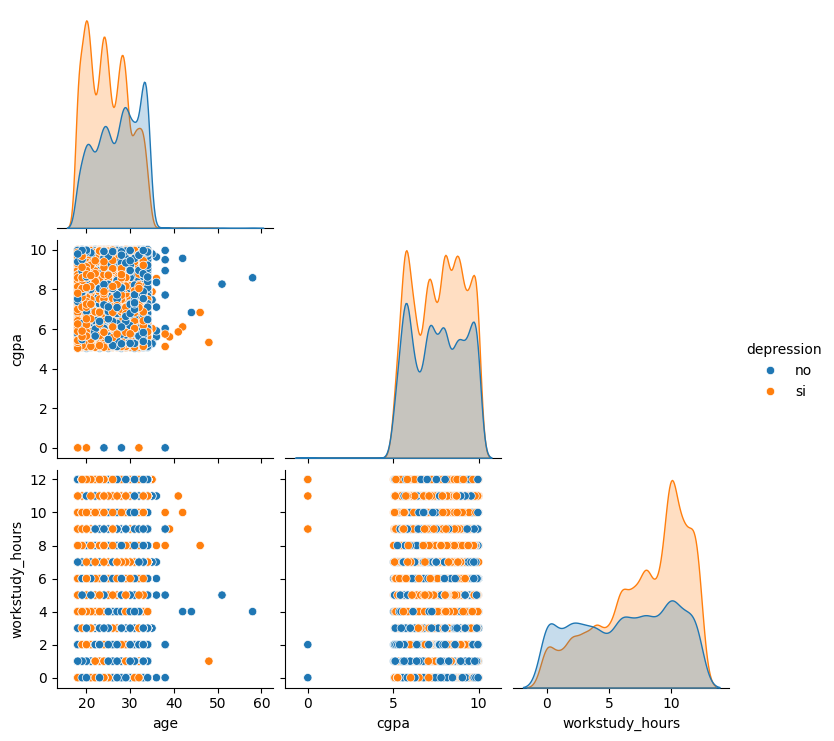

In [11]:
sns.pairplot(df_train, hue = "depression",corner=True)
plt.show()

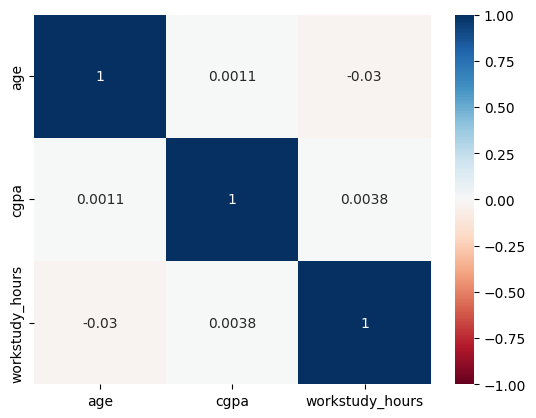

In [12]:
sns.heatmap(data=df_train.select_dtypes('number').corr(),vmin=-1,vmax=1,cmap='RdBu',annot=True)
plt.show()

In [13]:
var = ['gender','age', 'cgpa','have_you_ever_had_suicidal_thoughts_','workstudy_hours','family_history_of_mental_illness']
X_train = df_train[var]
y_train = df_train['depression'].copy()
X_val = df_val[var]
y_val = df_val['depression'].copy()
X_test = df_test[var]
y_test = df_test['depression'].copy()

In [14]:
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_val_enc = label_encoder.transform(y_val)
y_test_enc = label_encoder.transform(y_test)

In [15]:
cat_cols = X_train.select_dtypes("category").columns
num_cols = X_train.select_dtypes("number").columns

cat_proc = Pipeline([
    ("one_hot", OneHotEncoder(drop="first", handle_unknown='ignore'))
])
num_proc = Pipeline([
    ("powertransform", PowerTransformer())
])

proccesor = ColumnTransformer(
    [
        ("cat", cat_proc, cat_cols),
        ("num", num_proc, num_cols)
    ]
)

In [16]:
clf_rforest_p = Pipeline([
    ("preproccesor", proccesor),
    ("rforest", RandomForestClassifier(random_state=2025, class_weight='balanced')),
])

In [17]:
clf_rforest_p.fit(X_train, y_train_enc)

Pipeline(steps=[('preproccesor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('one_hot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  Index(['gender', 'have_you_ever_had_suicidal_thoughts_',
       'family_history_of_mental_illness'],
      dtype='object')),
                                                 ('num',
                                                  Pipeline(steps=[('powertransform',
                                                                   PowerTransformer())]),
                                                  Index(['age', 'cgpa', 'workstudy_hours'], dtype='object'))])),
                ('rforest',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=2025))])

accuracy: 72.38
Matthews Correlation Coefficient: 42.89
f1 score: 76.63
              precision    recall  f1-score   support

          no       0.67      0.65      0.66      1850
          si       0.76      0.77      0.77      2614

    accuracy                           0.72      4464
   macro avg       0.72      0.71      0.71      4464
weighted avg       0.72      0.72      0.72      4464



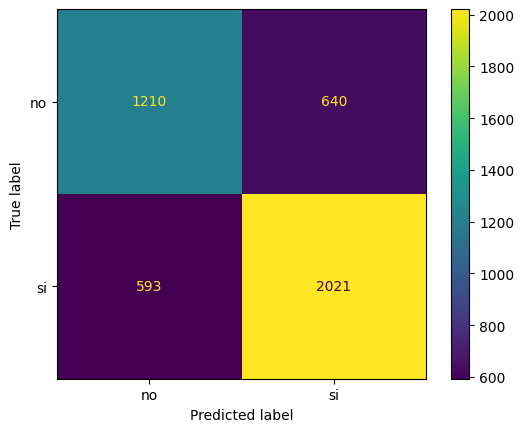

In [18]:
y_hat_val = clf_rforest_p.predict(X_val)
print(f'accuracy: {accuracy_score(y_val_enc,y_hat_val)*100:.2f}')
print(f'Matthews Correlation Coefficient: {matthews_corrcoef(y_val_enc,y_hat_val)*100:.2f}')
print(f'f1 score: {f1_score(y_val_enc,y_hat_val)*100:.2f}')
print(classification_report(y_val_enc,y_hat_val,target_names = label_encoder.classes_))
ConfusionMatrixDisplay.from_predictions(y_val_enc, y_hat_val, display_labels= label_encoder.classes_)
plt.show()

accuracy: 73.36
Matthews Correlation Coefficient: 45.07
f1 score: 77.28
              precision    recall  f1-score   support

          no       0.68      0.68      0.68      2313
          si       0.77      0.77      0.77      3268

    accuracy                           0.73      5581
   macro avg       0.73      0.73      0.73      5581
weighted avg       0.73      0.73      0.73      5581



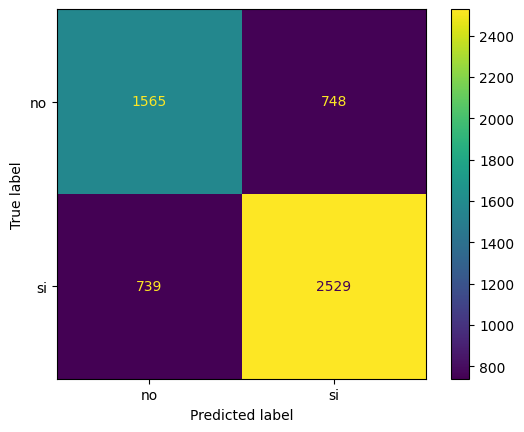

In [19]:
y_hat_test = clf_rforest_p.predict(X_test)
print(f'accuracy: {accuracy_score(y_test_enc,y_hat_test)*100:.2f}')
print(f'Matthews Correlation Coefficient: {matthews_corrcoef(y_test_enc,y_hat_test)*100:.2f}')
print(f'f1 score: {f1_score(y_test_enc,y_hat_test)*100:.2f}')
print(classification_report(y_test_enc,y_hat_test,target_names = label_encoder.classes_))
ConfusionMatrixDisplay.from_predictions(y_test_enc,y_hat_test, display_labels= label_encoder.classes_)
plt.show()

Las metricas de test y validación son muy similares, el coeficiente de correlacion Matthews, tiene una correlación positiva moderada entre las predicciones y los valores reales; pero vamos a optimizar los parametros para ver si mejora las metricas.

In [20]:
clf_rforest_cv = GridSearchCV(
    clf_rforest_p,
    param_grid={
        "rforest__max_depth": [3,5,7,9],
        "rforest__n_estimators": [20,30,50,100],
        },
    cv=5,
    scoring='f1',
    n_jobs = -1 # usa todos los trabajadores que puedas
)

In [21]:
clf_rforest_cv.fit(X_train, y_train_enc)
clf_rforest_cv.best_params_

{'rforest__max_depth': 3, 'rforest__n_estimators': 50}

accuracy: 77.55
Matthews Correlation Coefficient: 53.36
f1 score: 81.32
              precision    recall  f1-score   support

          no       0.75      0.69      0.72      1850
          si       0.79      0.83      0.81      2614

    accuracy                           0.78      4464
   macro avg       0.77      0.76      0.77      4464
weighted avg       0.77      0.78      0.77      4464



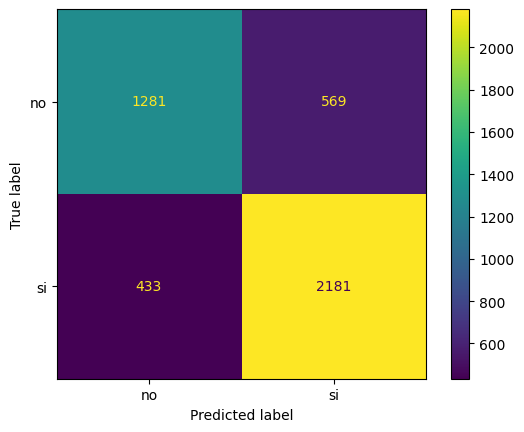

In [22]:
y_hat_val = clf_rforest_cv.predict(X_val)
print(f'accuracy: {accuracy_score(y_val_enc,y_hat_val)*100:.2f}')
print(f'Matthews Correlation Coefficient: {matthews_corrcoef(y_val_enc,y_hat_val)*100:.2f}')
print(f'f1 score: {f1_score(y_val_enc,y_hat_val)*100:.2f}')
print(classification_report(y_val_enc,y_hat_val,target_names = label_encoder.classes_))
ConfusionMatrixDisplay.from_predictions(y_val_enc,y_hat_val, display_labels= label_encoder.classes_)
plt.show()

accuracy: 78.34
Matthews Correlation Coefficient: 55.09
f1 score: 81.83
              precision    recall  f1-score   support

          no       0.75      0.71      0.73      2313
          si       0.80      0.83      0.82      3268

    accuracy                           0.78      5581
   macro avg       0.78      0.77      0.78      5581
weighted avg       0.78      0.78      0.78      5581



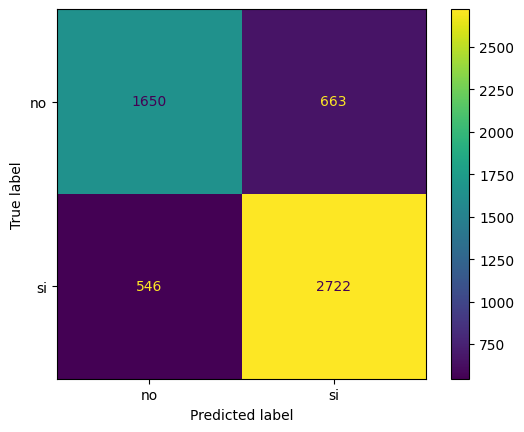

In [23]:
y_hat_test = clf_rforest_cv.predict(X_test)
print(f'accuracy: {accuracy_score(y_test_enc,y_hat_test)*100:.2f}')
print(f'Matthews Correlation Coefficient: {matthews_corrcoef(y_test_enc,y_hat_test)*100:.2f}')
print(f'f1 score: {f1_score(y_test_enc,y_hat_test)*100:.2f}')
print(classification_report(y_test_enc,y_hat_test,target_names = label_encoder.classes_))
ConfusionMatrixDisplay.from_predictions(y_test_enc,y_hat_test, display_labels= label_encoder.classes_)
plt.show()

Con la optimización de los parametros, las tres métricas suben bastante, asi que nos quedamos con este nuevo modelo. 

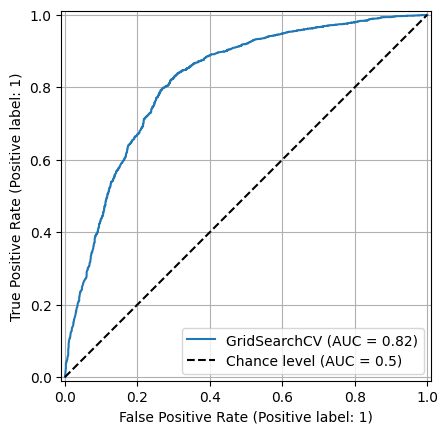

In [24]:
RocCurveDisplay.from_estimator(
    clf_rforest_cv, X_val, y_val_enc, plot_chance_level=True
)
plt.grid(True)
plt.show()

Aqui podemos ver en esta grafica que el AUC es muy bueno, este es un buen modelo

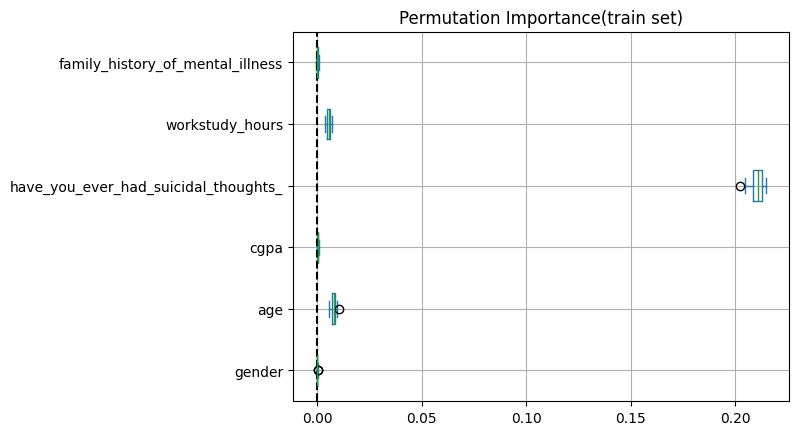

In [25]:
importance = permutation_importance(clf_rforest_cv,X_train,y_train_enc,n_repeats=25,random_state=2025)
importance_df = pd.DataFrame(importance.importances.T,columns=X_train.columns)
ax = importance_df.plot.box(vert=False)
ax.axvline(x=0,color="k",linestyle="--")
ax.set_title("Permutation Importance(train set)")
ax.grid(True)
plt.show()

En el gráfico de la importancia de las variables, se observa que la mejor variable es 'have_you_ever_had_suicidal_thoughts_?', seguido por la 'age', y 'work/study_hours', las otras aportan al modelo pero no tanto como las tres que nombre.

In [26]:
model_dict = {
    "model": clf_rforest_cv,
    "predictors": X_train.columns,
    "algorithm_name": "Random forest classifier",
    "metrics": "accuracy: 0.78, f1 score: 0.82, Matthews Correlation Coefficient: 0.55",
    "author" : "Nallely Quintero",
    "classes" : "0:no,1:si"
}

In [27]:
with open("../app/models/depression_rforest_model.pkl", "wb") as depression_rforest:
    pickle.dump(clf_rforest_cv, depression_rforest)

In [28]:
with open("../app/models/depression_rforest_model.pkl", "rb") as file:
    modelx = pickle.load(file)

In [29]:
with open('../app/models/proccesor.pkl', 'wb') as file:  
    pickle.dump(proccesor, file)

In [30]:
predict_df = pd.DataFrame({'gender':["Female"], 'age':[19.0], 'cgpa':[8.04], 'have_you_ever_had_suicidal_thoughts_':["Yes"], 'workstudy_hours': [12.0], 'family_history_of_mental_illness':["Yes"]})
predict_df

,gender,age,cgpa,have_you_ever_had_suicidal_thoughts_,workstudy_hours,family_history_of_mental_illness
0,Female,19.0,8.04,Yes,12.0,Yes


In [31]:
modelx.predict(predict_df)

array([1])